# Loading in the dataset

In [2]:
import pandas as pd
import numpy as np
import json
import requests
import os
import re
import pymc3 as pm

from FE import FE

In [3]:
wine = pd.read_csv('winemag-data-130k-v2.csv')

In [4]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


do we care about taster_name? What can we do with province, region_1, region2?

## Data cleaning

In [5]:
wine_clean = FE(wine)

In [6]:
wine_clean.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,continent,color,category,score_descriptive
id,,,,,,,,,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,europe,white,3,Very Good
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,europe,red,0,Very Good
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,north_america,red,0,Very Good
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,north_america,white,0,Very Good
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,north_america,red,3,Very Good


#### We can group the scores categorically to produce a naive bayes estimator

![Score Overview](group.png)

In [7]:
wine_clean['variety'].describe()

count         129970
unique           707
top       Pinot Noir
freq           13272
Name: variety, dtype: object

In [6]:
wine_clean.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,continent,color,category,score_descriptive
id,,,,,,,,,,,,,,,,,,
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,europe,white,3,Very Good
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,europe,red,0,Very Good
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,north_america,red,0,Very Good
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,north_america,white,0,Very Good
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,north_america,red,3,Very Good


In [8]:
# Initial Bayesian Linear Regression
colsToDrop = ["description","designation","province", "region_1","region_2","taster_name","taster_twitter_handle","title", "variety","category","score_descriptive"]

# Drop where we don't have region data
regression = wine_clean.query('country.notnull()', engine='python').drop(colsToDrop, axis=1)

# Break out categorical & one-hot encode
regression_categorical = pd.get_dummies(regression[['country','winery', 'year','continent', 'color']])

# Break out continuous & scale
regression_continuous = (regression['price'] - regression['price'].mean())/regression['price'].std()

# Scale Y
Y = (regression['points'] - regression['points'].mean())/regression['points'].std()


In [ ]:
with pm.Model() as model: 
    zbeta0 = pm.Normal('zbeta0', mu=0, sd=2)
    zbetaj_cont = pm.Normal('zbetaj_cont', mu=0, sd=2)
    zbetaj_cat = pm.Beta('zbetaj_cat', alpha = 1, beta = 1)
    
    zmu =  zbeta0 + pm.math.dot(zbetaj_cont, regression_continuous.T) + pm.math.dot(zbetaj_cat, regression_categorical.T)
        
    nu = pm.Exponential('nu', 1/29.)
    zsigma = pm.Uniform('zsigma', 10**-5, 10)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=zmu, lam=1/zsigma**2, observed=Y)

In [56]:
with model:
    trace = pm.sample(10000, cores = 4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zsigma, nu, zbetaj, zbeta0]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:48<00:00, 873.74draws/s] 


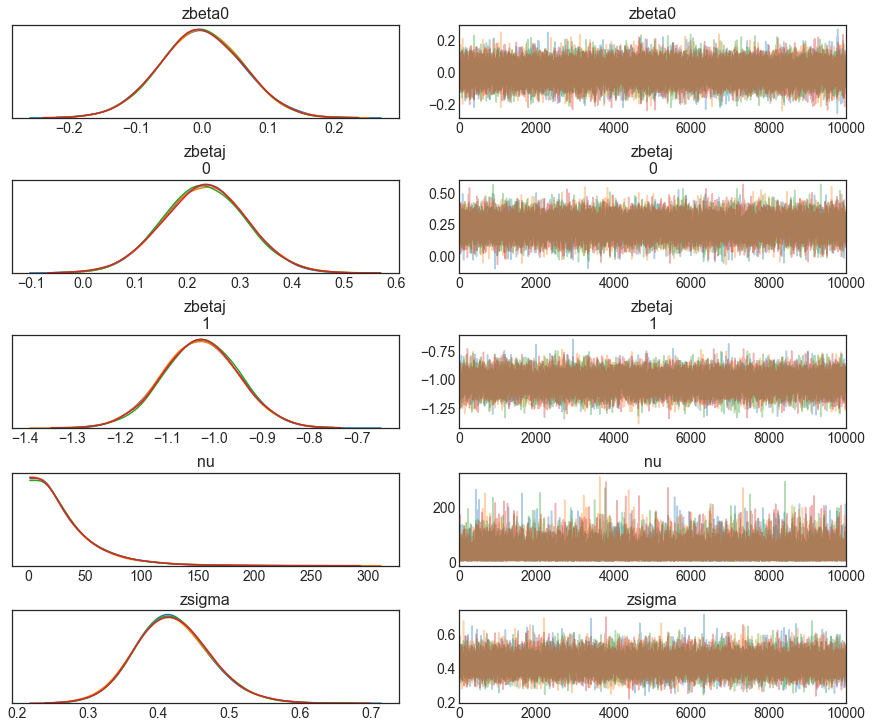

In [57]:
pm.traceplot(trace);